# Moment and Information projections 

First we import stuff we need. To get this to run one needs to pip install scipy, matplotlib, and numpy

In [1]:
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

### Define target distribution -- a Mixture of Gaussians
This is the "p-distribution", the distribution we want to approximate. The function takes input x, the point at which we evaluate the distribution, plus a number of optional variables. The optional variables are not used. The reason why the function has the option for parameters anyway is that it now gets the same interface as "q_distribution" below.

The distribution defined is a Mixture-Of-Gaussians with two kernels.
Change the behaviour of the function simply by changing the parameters called `w` (weight of first Gaussian component), `mean1`, `stddev1`, `mean2` and `stddev2`.

In [2]:
def p_distribution_pdf(x, **kwargs):
    """This is the target distribution. It only uses x, but is equipped with kwargs
    to simplify interface -- now p_distribution and q_distribution (defined below) are exchangeable """
    w = 0.1
    mean1 = 1
    stddev1 = .5
    mean2 = 10
    stddev2 = 3
    
    return w * norm.pdf(x, loc=mean1, scale=stddev1) + (1-w) * norm.pdf(x, loc=mean2, scale=stddev2)

## Make a fancy plot
Note that if the parameters of the p_distribution as described above are changed from their initial values (.1, 1, .5, 10, and  3, respectively) the plot here and below may not look good -- the range of the $x$-axis is hardcoded to be [-5, +25]. For simplicity of implementation below, make sure that all the probability mass of your target distribution is within this range. 

### --> If the plot looks bad you should not change the parameters as drastically as you have done.

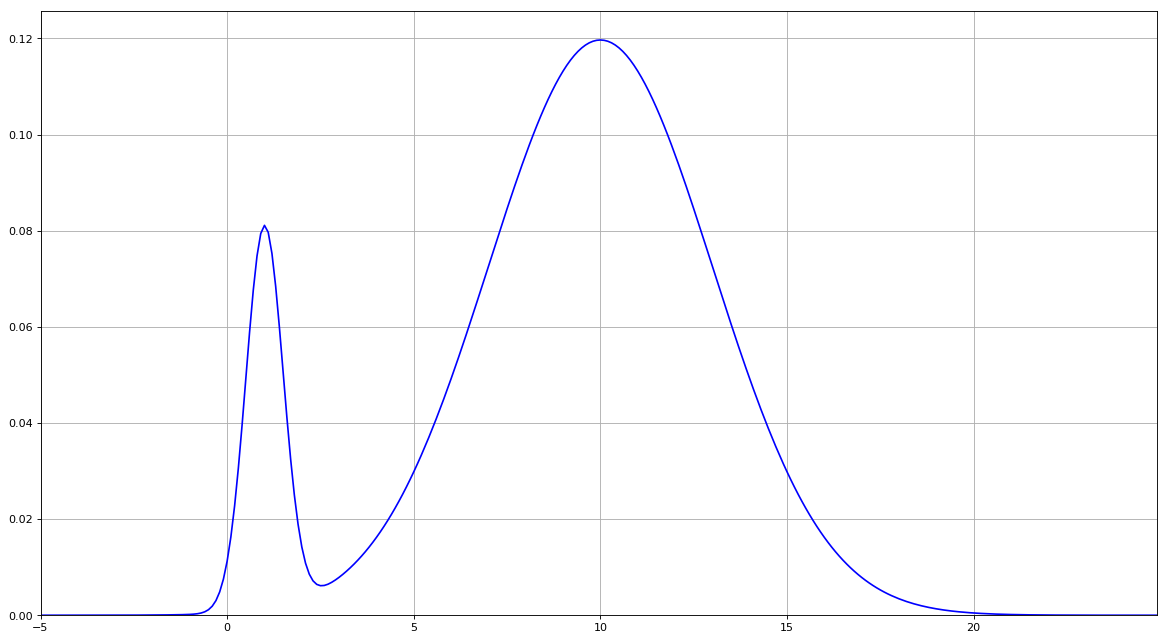

In [3]:
x_values = np.arange(-5, +25, .1)
plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(x_values, p_distribution_pdf(x_values), 'b-')
plt.xlim([np.min(x_values), np.max(x_values)])
plt.ylim([0, plt.ylim()[1]])
plt.grid()
plt.show()

### Define approximate distribution -- a single Gaussian with unknown loc (mean) and scale (standard deviation)
The q_distribution is our approximation. We send in `loc` (mean) and `scale` (std.dev). Hence a call to this function will be like `q_distribution(x=1., loc=0.1, scale=2.)`.

In [4]:
def q_distribution_pdf(x, **kwargs):
    """This is the pdf of approximate distribution.
    We assume that to be Normal, and send in loc and scale through the kwargs"""
    loc = kwargs.get('loc')
    scale = kwargs.get('scale')
    return np.maximum(1e-6, norm.pdf(x=x, loc=loc, scale=scale))

### The general vehicle for optimization: Do numerical optimization of a KL divergence wrt location and scale of the q-distribution. 
KL calculation can be made in a standard (and very un-optimized) way by implementing naive numerical integration. Note the general interface: It takes a function f, a function g and a value indicating how "exact" to be during numerical optiization. The internal function `calculate_KL_for_given_parameters` will return the numerical approimation of the integral $\int_x f(x) \log( f(x)/g(x) ) \, dx$ for given parameters $\mu$ and $\sigma$. 

The functions `f` and `g` should point to either `p_distribution_pdf` or `q_distribution_pdf` defined above, so that one uses the $p$-distribution, the other the $q$-distribution. The code in this function does not know if it is `f` or `g` that points to `q_distribution_pdf`, which is where the parameters come into play. Therefore, we send the parameters to evaluation of both `f` and `g` (this works, because we defined the interface of `p_distribution_pdf` and `q_distribution_pdf` identically, even though only `q_distribution_pdf` utilizes the parameters.)

Finally, optimize_parameters will kcik off `minimize`, which is imported from `scipy`.

In [5]:
def optimize_parameters(f, g, eps):
    """
    The work-horse for the optimization. Takes two functions f and g as input.
    One of these is the p-function above, the other is the q-function.
    This method does not care which is which.
    (Implementation trick: Note that while both the p-func and the q-func accept loc and scale as input through
    **kwargs, only the q-function actually uses that input. This, however, ensures that we in this function can
    consider p and q as "exchangeable").
    The function  calculates KL(f||g) through (naive) numerical integration, and returns the mu-sigma-pair that
    minimizes the KL.
    :param f: An executable function that accepts inputs x, loc, shape which returns a vector of the same shape as x
    :param g: An executable function that accepts inputs x, loc, shape which returns a vector of the same shape as x
    :param eps: Step-size for the numerical integration
    :return: Parameters - a vector of [mu, sigma]
    """

    def calculate_KL_for_given_parameters(parameters):
        """
        Calculate the KL(f||g) using the given parameters. 
        Both f and g are already set (in the surrounding scope); 
        one is p_distribution the other is q_distribuiton. eps is also set in the outer scope. 
        This is important beause the interface to scipy's minimize requires you send in a function 
        that *only* takes a list containing the parameters we try to optimize as input.
        
        Do the calculation using numeric integration: 
        At several equally-distanced points along the x-axis, (called x_i, =0, 1, ...) we calculate 
        f(x_i) * log(f(x_i) / g(x_i))
        Then sum all these values, and multiply by the length between x_i and x_(i+1). 
        Here np.sum() is helpful: It takes the elements of a list/vecotr and sums the contributions.
        np.log(y) will calculate the log of y.
        
        :param params: Parameter vector: [mu, sigma]
        :return: KL(f||g) 
        """
        mu = parameters[0]
        sigma = parameters[1]

        x_val = np.arange(-25, +25, eps)
        total = eps * np.sum(f(x_val, loc=mu, scale=sigma) *
                                    (np.log(f(x_val, loc=mu, scale=sigma))
                                     - np.log(g(x_val, loc=mu, scale=sigma))))
        return total
    
    """
    Find (approximate) optimal value using numerical optimization. 
    The minimize function from scipy will do this for us. 
    The call to minimize takes the following parameters:
        * a function to be minimized
        * bounds for the solution, a touple with one element per parameter, with lower and uper bounds.
               Here loc can be whatever, but for numerical stability it can be clever to ensure that 
               scale must be >= 1E-2 or something like that.
        * x0: The startingpoint for the optimization. Almost any value should work here, but it is useful
               to supply "something" to ensure that the startingpoint is legal (i.e., variance > 0)
    """
    optimum = minimize(calculate_KL_for_given_parameters, 
                       bounds=((None, None), (1E-2, None)), 
                       x0=[0, 5])
    
    # We only need the optimum, not all the extra info (like the minimal KL value), 
    # hence we only return the "x-slot", optimum['x']
    return optimum['x']

### Optimize KL(p||q) wrt q to get to the so-called moment estimator

In [6]:
def generate_moment_projection(eps=1E-2):
    """
    Generate the "Moment projection" (M-projection; K&F Def 8.4).
    This minimizes KL(p||q) wrt. q. Also known as the "expectation propagation loss".
    :param eps: The step-size for the numerical integration
    :param starting_point: Starting point for the optimization. Anything reasonable will work.
    :return: Parameters - a vector of [mu, sigma]
    """

    return optimize_parameters(f=p_distribution_pdf,
                               g=q_distribution_pdf,
                               eps=eps)

### Optimize KL(q||p) wrt q to get to the information estimator

In [7]:
def generate_information_projection(eps=1E-2):
    """
    Generate the "Information projection" (I-projection; K&F Def 8.4).
    This minimizes KL(q||p) wrt. q. Also known as "variational inference".
    :param eps: The step-size for the numerical integration
    :param starting_point: Starting point for the optimization.
    Anything reasonable will work.
    :return: Parameters - a vector of [mu, sigma]
    """
    return optimize_parameters(f=q_distribution_pdf,
                               g=p_distribution_pdf,
                               eps=eps)

### Do the work: Find both moment and information estimates

In [8]:
# Find moment estimate
moment_estimate = generate_moment_projection()
print("M-projection: mu = {:5.3f}, sigma = {:5.3f}".format(
    moment_estimate[0], moment_estimate[1]))

# Find information estimate
information_estimate = generate_information_projection()
print("I-projection: mu = {:5.3f}, sigma = {:5.3f}".format(
    information_estimate[0], information_estimate[1]))

M-projection: mu = 9.100, sigma = 3.926
I-projection: mu = 9.813, sigma = 3.224


### Make nice plot

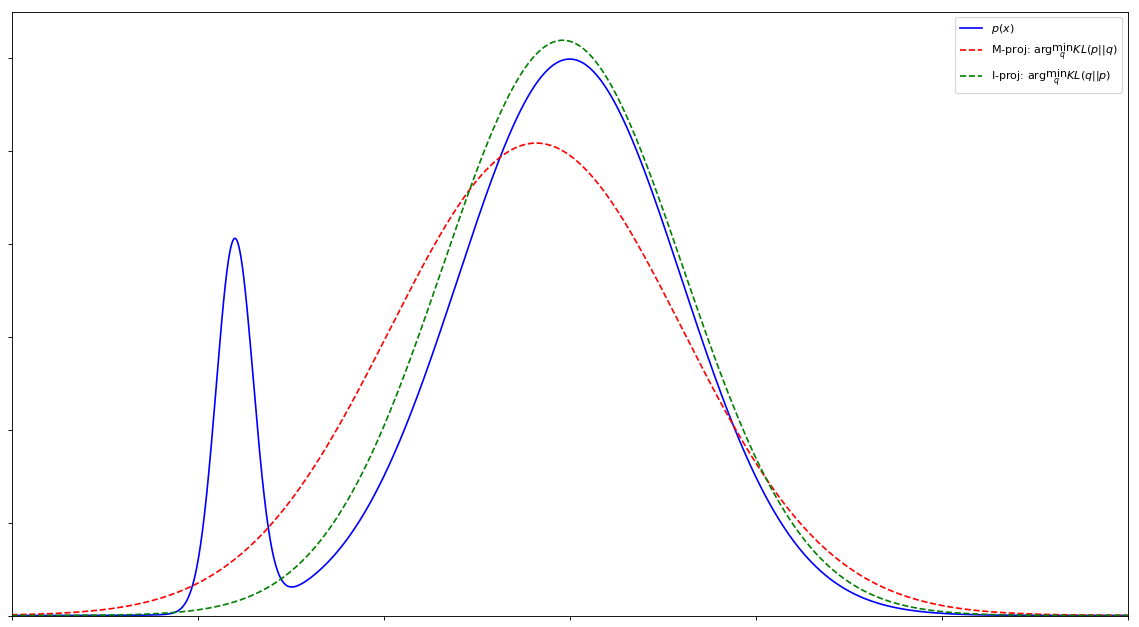

In [9]:
x_values = np.arange(-5, +25, .01)
plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(x_values, p_distribution_pdf(x_values), 'b-', label='$p(x)$')
plt.plot(x_values, q_distribution_pdf(x_values, loc=moment_estimate[0], scale=moment_estimate[1]),
         'r--', label='M-proj: $\\arg\\min_q KL(p||q)$')
plt.plot(x_values, q_distribution_pdf(x_values, loc=information_estimate[0], scale=information_estimate[1]),
         'g--', label='I-proj: $\\arg\\min_q KL(q||p)$')
plt.legend(loc='upper right')
plt.gca().axes.yaxis.set_ticklabels([])
plt.gca().axes.xaxis.set_ticklabels([])
plt.xlim([np.min(x_values), np.max(x_values)])
plt.ylim([0, plt.ylim()[1]])
plt.show()